In [1]:
import warnings

import matplotlib.pyplot as plt

import os.path as osp

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from src.datasets import DatasetBuilder
from src.models.classifiers import SimpleCNNtorch
from src.models.lightning_wrappers import ClassifierLightningWrapper 
from src.utils import seed_everything, get_config, load_model_weights, evaluate_classification_model

/data/leuven/365/vsc36567/miniconda3/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-12 13:05:56.958784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747047956.976504 3469646 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747047956.981994 3469646 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747047956.996713 3469646 computation_placer.cc:177] computation placer alrea

In [2]:
seed_everything()
warnings.filterwarnings("ignore", category=UserWarning)

## Setup a builder of the dataset and a config file

In [3]:
config_path = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/configs/train_classifier_fmnist.yaml"
# r"D:\PycharmProjects\CF-Robustness-Benchmark\configs\train_classifier_fmnist.yaml"
config = get_config(config_path)

In [4]:
# Uncomment for multiclass classification
config.data.classes = [0, 2, 4, 6]
config.data.num_classes = len(config.data.classes)

In [5]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

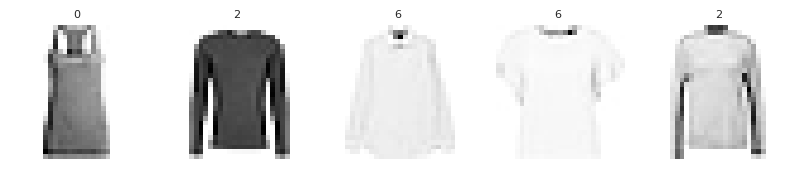

In [6]:
plt.style.use('seaborn-v0_8-darkgrid')

n_samples = 5
class_names = ds_builder.class_encodings
fig, axs = plt.subplots(1, n_samples, figsize=(10, 6))

batch = next(iter(train_loader))
images = batch[0][:n_samples]
labels = batch[1][:n_samples]

for i in range(n_samples):
    axs[i].imshow(images[i, ...].permute(1, 2, 0))
    axs[i].set_title(class_names[labels[i].item()], fontdict={'fontsize': 8})
    axs[i].axis("off")

### Build a classification model

In [12]:
model = SimpleCNNtorch(**config.classifier.args, 
                        img_size=config.data.img_size,
                        num_classes=config.data.num_classes)
lwrapper = ClassifierLightningWrapper(config, model)

In [13]:
expt_dir = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments"
# r"D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments"
expt_name = f"{config.data.name}_classification"
expt_version = "binary"  if config.data.num_classes == 2 else "multiclass"
checkpints_dir = osp.join(expt_dir, expt_name, expt_version, 'checkpoints')
classes4fname = ("_").join([str(i) for i in class_names.values()]) if config.data.num_classes == 2 else ""

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=5,
    verbose=False,
    mode="min",

)

chekpoint_callback = ModelCheckpoint(
    monitor="val_accuracy",
    dirpath=checkpints_dir,
    filename=f"{config.data.name}_{classes4fname}_{{epoch:02d}}_{{val_accuracy:.2f}}",
    save_top_k=1,
    mode="max",
    save_weights_only=True,
)
chekpoint_callback.FILE_EXTENSION = '.pth'

tb_logger = TensorBoardLogger(save_dir=expt_dir, name=expt_name, version=expt_version)

trainer = Trainer(
    log_every_n_steps=10,
    max_epochs=config.epochs+3,
    enable_checkpointing=True,
    callbacks=[early_stop_callback, chekpoint_callback],
    logger=tb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model=lwrapper, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | SimpleCNNtorch   | 25.3 K | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | valid_metrics | MetricCollection | 0      | train
-----------------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=13` reached.


In [ ]:
model_weights_path = r"D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\mnist_classification\binary\checkpoints\mnist_1_8_epoch=08_val_loss=0.00.pth"
loaded_model = SimpleCNNtorch(config.input_channels, 
                        config.data.img_size,
                        config.data.num_classes,
                        in_conv_channels=[1, 8, 16],
                        out_conv_channels=[8, 16, 32],
                        conv_kernels=[7, 5, 3],
                        softmax_flag=True)

print('Total number of parameters in the CNN:', loaded_model.get_params_num())

load_model_weights(loaded_model, framework="torch", weights_path=model_weights_path)
evaluate_classification_model(loaded_model, test_loader, config.data.num_classes)

## Classification on DermaMNIST

In [4]:
config_path = r"D:\PycharmProjects\CF-Robustness-Benchmark\configs\train_classifier_derma.yaml"
config = get_config(config_path)

ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

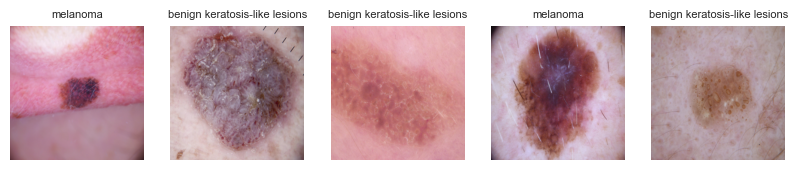

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')

n_samples = 5
class_names = ds_builder.class_encodings
fig, axs = plt.subplots(1, n_samples, figsize=(10, 6))

batch = next(iter(train_loader))
images = batch[0][:n_samples]
labels = batch[1][:n_samples]

for i in range(n_samples):
    axs[i].imshow(images[i, ...].permute(1, 2, 0))
    axs[i].set_title(class_names[labels[i].item()], fontdict={'fontsize': 8})
    axs[i].axis("off")

In [6]:
model = SimpleCNNtorch(config.input_channels, 
                        config.data.img_size,
                        config.data.num_classes,
                        softmax_flag=True)

In [ ]:
# config.optimizer = torch.optim.Adam
# config.loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [8]:
lg_wrapper = ClassifierLightningWrapper(config, model)

In [9]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode="min",
)
mlf_logger = MLFlowLogger(experiment_name="lightning_logs", tracking_uri="file:./ml-runs")

trainer = Trainer(
    log_every_n_steps=5,
    max_epochs=15,
    enable_checkpointing=True,
    callbacks=[early_stop_callback],
    logger=mlf_logger
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model=lg_wrapper, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader)


  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | classifier    | SimpleCNNtorch   | 555 K  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | valid_metrics | MetricCollection | 0      | train
-----------------------------------------------------------
555 K     Trainable params
0         Non-trainable params
555 K     Total params
2.222     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 62/62 [00:10<00:00,  6.03it/s, v_num=cdef, train_loss_step=0.382, val_loss=0.491, valid_accuracy=0.778, valid_auc=0.802, train_loss_epoch=0.547, train_accuracy=0.715, train_auc=0.715]


In [ ]:
# How to correctly log results of experiments
# How to set a name to the experiment
# How to better version the experiments 